## APhys Group Meeting, 11.02.2026

In [30]:
# imports
import ewgreaders as ewg
import pylake
import os
from glob import glob
import json
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime
import warnings; warnings.filterwarnings('ignore')

CTD

Increase in temperature below thermocline.

In [2]:
def extract_profile_locations(dpath_L1, oom=True):
    profile_locs = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # Swiss coordinates
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)

        # bathymetry
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()
        
        profile_locs.append({
            'name': ds.attrs['Profile name'],
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth
        })

    return pd.DataFrame(profile_locs).sort_values('ysc', ascending=False).reset_index(drop=True), bathy

def plot_profiles_map_bathy(profile_locs, bathy):
    # don't doule plot duplicates
    profile_locs = profile_locs.drop_duplicates(subset='name')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), width_ratios=[1.2, 1])

    # map
    im = ax[0].pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Greys_r', vmin=0)
    cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', location='left', pad=0.13, ax=ax[0])
    cbar.ax.invert_yaxis()

    # bathymetry
    sns.lineplot(profile_locs, x='ysc', y='total_depth', marker='o', ax=ax[1])
    
    # profile locations
    for _, p in profile_locs.iterrows():
        ax[0].scatter(p['xsc'], p['ysc'], c='steelblue', edgecolor='black', marker='o')
        ax[0].annotate(p['name'], (p['xsc'], p['ysc']), color='red', xytext=(3,0), textcoords='offset points')
        ax[1].annotate(p['name'], (p['ysc'], p['total_depth']), color='red', xytext=(0,5), textcoords='offset points')
        

    ax[1].set_xlabel('Y Swiss Coordinate')
    ax[1].set_ylabel('Depth [m]')

    ax[1].set_ylim(0, 205)
    ax[1].invert_xaxis()
    ax[1].invert_yaxis()
    ax[1].grid()
    ax[1].spines[['right', 'top']].set_visible(False)

    plt.tight_layout(w_pad=2)
    plt.show()

def extract_data_vars(dpath_L1, var, oom=True):
    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        if var == 'rho':
            mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['Cond_qual'] == 0)
        else:
            mask = (ds['depth'].notnull()) & (ds[f'{var}_qual'] == 0)
        depth = ds['depth'][mask]
        vals = ds[var][mask]

        if var == 'DO_mg':    # convert to umol/L
            vals *= (1000/32)

        dat = pd.DataFrame({
            'depth': depth,
            var : vals
        })
        dat[['name', 'time', 'xsc', 'ysc', 'total_depth']] = name, time, xsc, ysc, total_depth
        data.append(dat)

    return pd.concat(data, ignore_index=True).sort_values(by=['time', 'depth'], ascending=True).reset_index(drop=True)

def plot_profiles_transect(data, var, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]
    
    fig, ax = plt.subplots(nrows=1, ncols=len(df['time'].unique()), figsize=(15, 5), sharex=True, sharey=True)
    if var == 'Temp':
        color = 'steelblue'
    elif var == 'DO_mg':
        color = 'green'
    elif var == 'rho':
        color = 'orange'
    elif var == 'Turb':
        color = 'brown'

    for i, (t, dat) in enumerate(df.groupby('time', sort=False)):
        ax[i].plot(dat[var], dat['depth'], color=color)
        ax[i].axhline(dat['total_depth'].unique()[0], color='gray', ls='--')

        ax[i].set_title(dat['name'].unique()[0])
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].grid(True)

    ax[0].set_ylabel('Depth [m]')
    ax[0].invert_yaxis()

    if var == 'Temp':
        fig.supxlabel('Temperature [°C]')
    elif var == 'DO_mg':
        fig.supxlabel('Dissolved Oxygen Concentration [mg/L]')
    elif var == 'rho':
        fig.supxlabel('Density [kg/m^3]')
    elif var == 'Turb':
        fig.supxlabel('Turbidity [FTU]')

    plt.tight_layout(w_pad=0.5)
    plt.show()

In [3]:
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260128'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

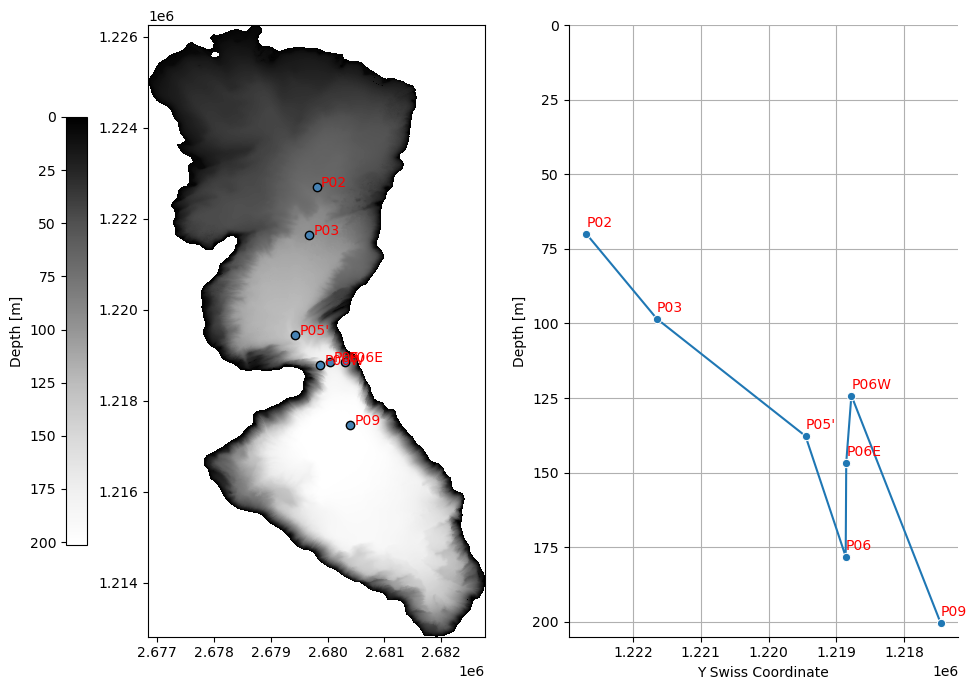

In [4]:
profile_locs, bathy = extract_profile_locations(dpath_L1)
plot_profiles_map_bathy(profile_locs, bathy)

In [5]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
rho_data = extract_data_vars(dpath_L1, 'rho')

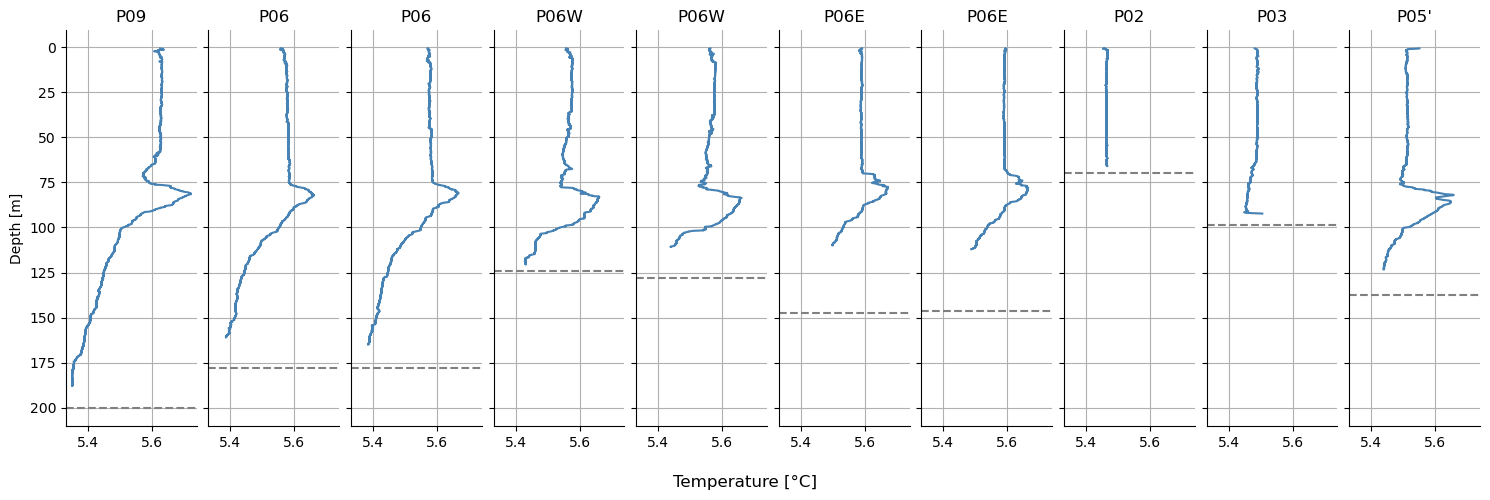

In [6]:
plot_profiles_transect(temp_data, 'Temp')

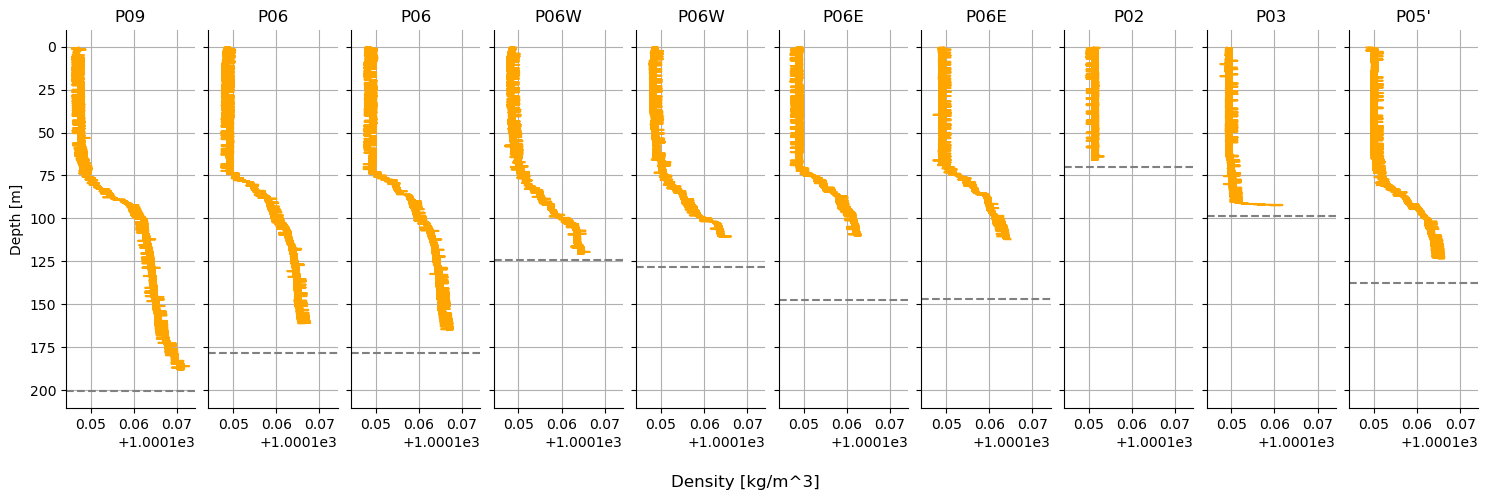

In [7]:
plot_profiles_transect(rho_data, 'rho')

In [8]:
date = '20260130'
dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

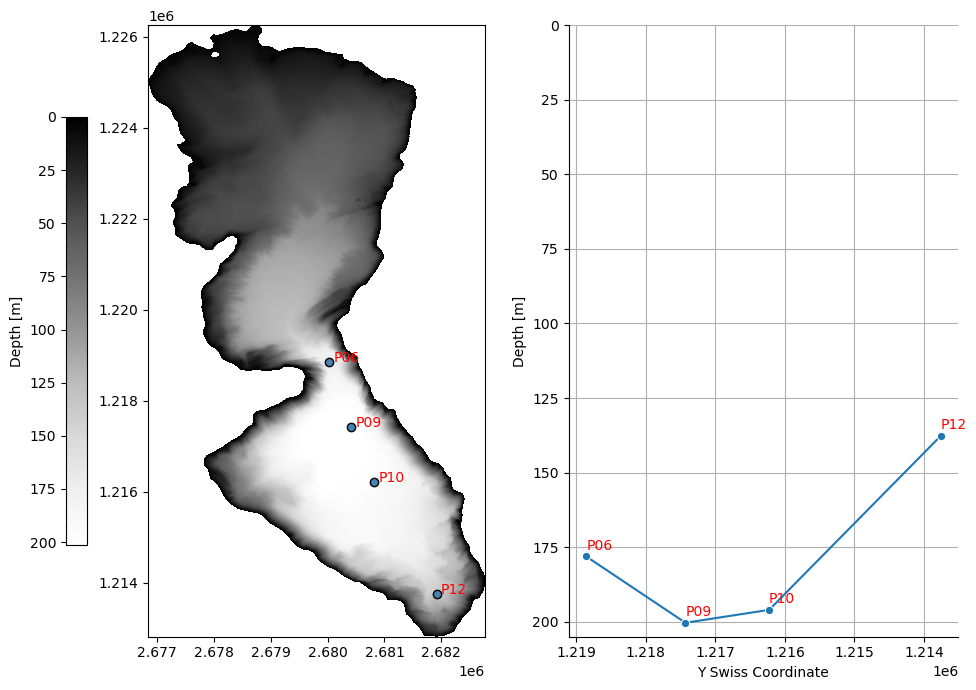

In [9]:
profile_locs, bathy = extract_profile_locations(dpath_L1)
plot_profiles_map_bathy(profile_locs, bathy)

In [10]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
rho_data = extract_data_vars(dpath_L1, 'rho')

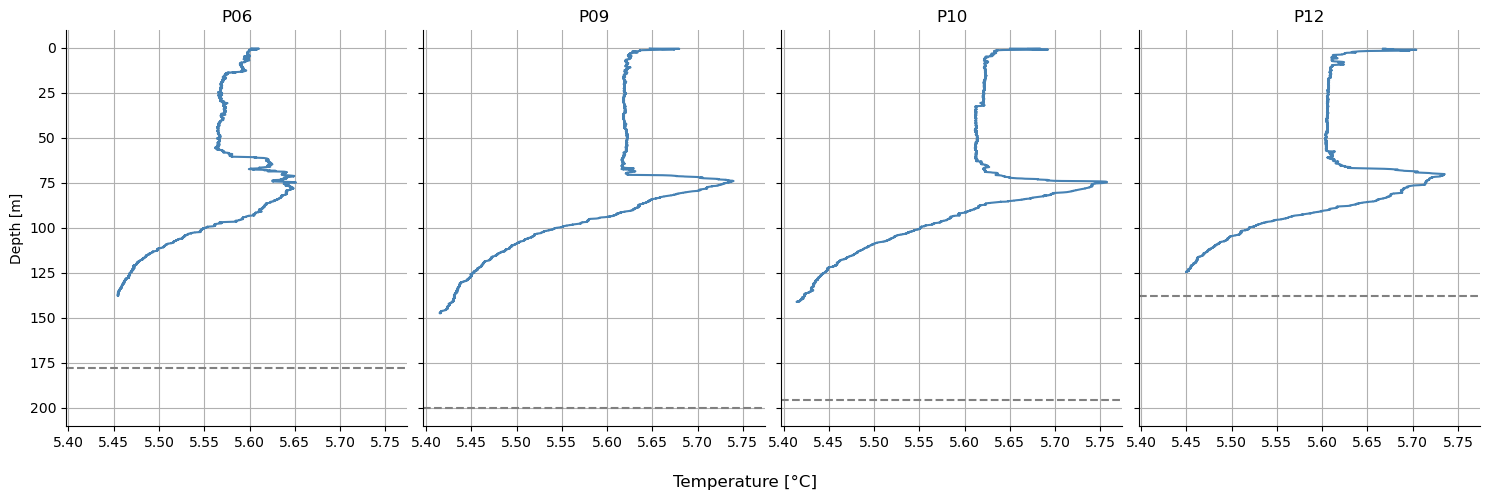

In [11]:
plot_profiles_transect(temp_data, 'Temp')

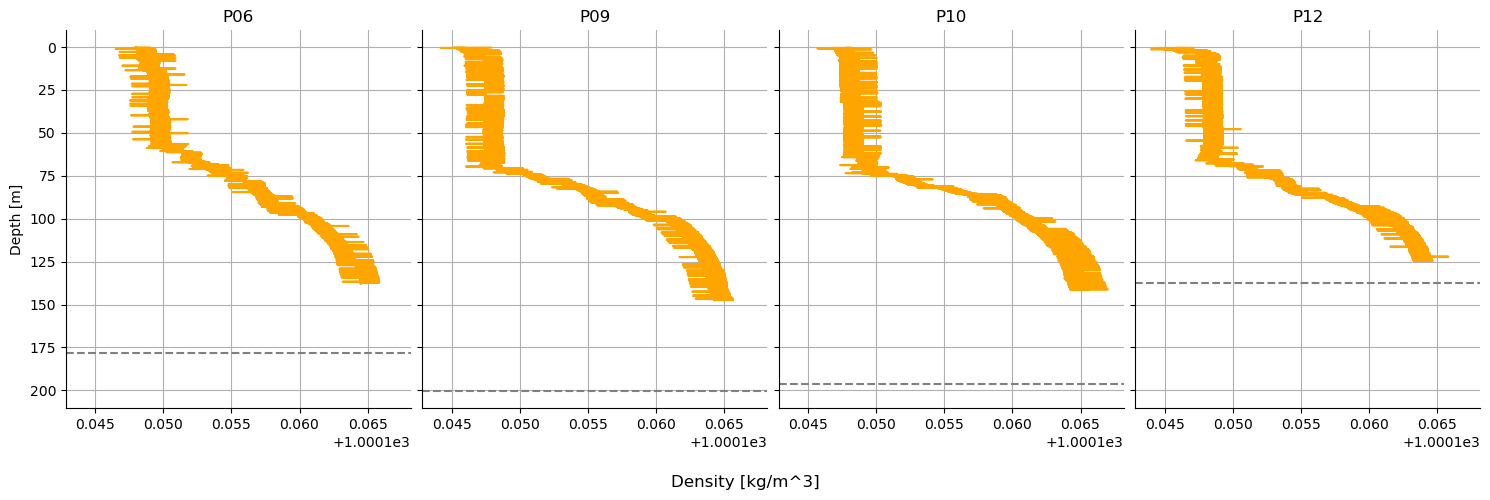

In [12]:
plot_profiles_transect(rho_data, 'rho')

In [13]:
lake = 'Zugersee'
location = 'LZN'
year = '2026'
date = '20260114'

t_start = '2025-11-06'
t_end = '2026-01-27'

In [15]:
mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
thermistors = mreader.get_thermistors()

In [16]:
ds_chain = []
for t in thermistors:
    serial_id = t['serial_id']

    try:
        treader = ewg.thermistor_reader.ThermistorReader(serial_id, lake, location, year, date)
        ds = treader.load_from_L0()
        ds = ds.sel(time=slice(t_start, t_end))
        ds_chain.append(ds)
    except Exception as e:
        print(f"Could not load data for thermistor {serial_id}: {e}")

ds_temp = mreader.create_instrument_chain(ds_chain)

Could not load data for thermistor 205533: Unsupported RSK type: processing
Could not load data for thermistor 200578: Could not find single data file for 200578.


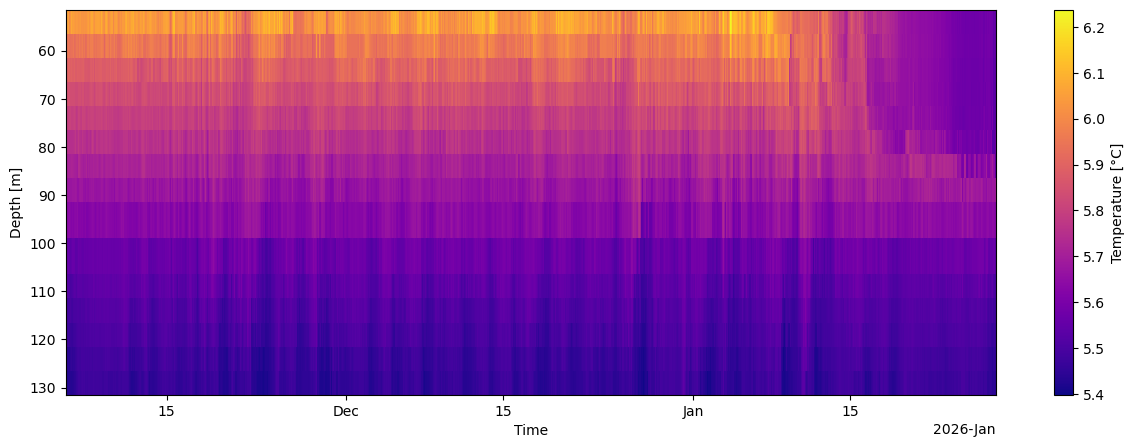

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_temp.temp.plot(cmap='plasma', ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Temperature [°C]")

ax.invert_yaxis()
plt.show()

### ADCPs

In [18]:
mooring_locs = pd.DataFrame({
    'name': ['LZC', 'LZN', 'LZW', 'LZE', 'LZW_plan', 'LZE_plan'],
    'xsc': [680091, 679423, 679912, 680314, 679850, 680330],
    'ysc': [218814, 219370, 218760, 218883, 218750, 218875],
    'echosound_depth': [177, 136, 132, 138, np.nan, np.nan]
})

mooring_locs['xsc'] += int(2e6)
mooring_locs['ysc'] += int(1e6)

mooring_locs['bathy_depth'] = [bathy.sel(xsc=row.xsc, ysc=row.ysc).depth.item() for _, row in mooring_locs.iterrows()]

mooring_locs

,name,xsc,ysc,echosound_depth,bathy_depth
0,LZC,2680091,1218814,177.0,177.53000
1,LZN,2679423,1219370,136.0,139.25000
2,LZW,2679912,1218760,132.0,145.17999
3,LZE,2680314,1218883,138.0,143.06000
4,LZW_plan,2679850,1218750,NaN,121.60001
5,LZE_plan,2680330,1218875,NaN,114.80002


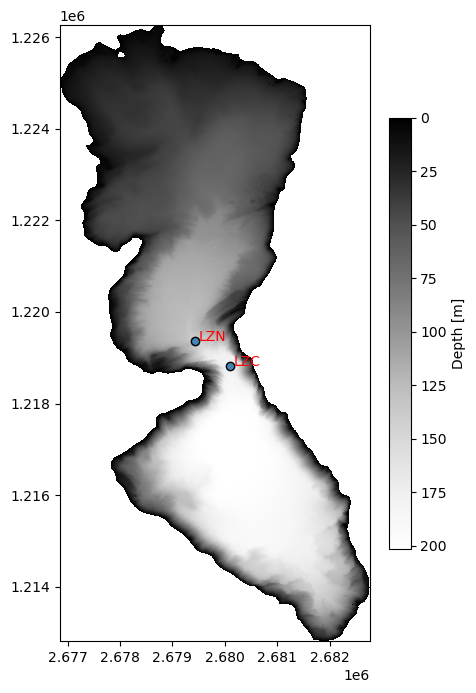

In [20]:
fig, ax = plt.subplots(figsize=(5, 8))   # figsize=(5, 8)

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Greys_r', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

for _, row in mooring_locs.iterrows():
    if row['name'] in ['LZC', 'LZN']:
        ax.scatter(row.xsc, row.ysc, c='steelblue', edgecolor='black')
        ax.annotate(row['name'], (row.xsc, row.ysc), color='red', xytext=(3, 0), textcoords='offset points')


plt.show()

In [31]:
lake = 'Zugersee'
location = 'LZC'
year = '2026'
date = '20260114'

t_start = '2025-11-01'
t_end = '2026-01-13'

In [32]:
mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
adcps = mreader.get_adcps()

In [33]:
adcp = adcps[-1]
serial_id = adcp['serial_id']
areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
fpath = areader.locate_data_file('L0')
ds = areader.load_from_L0(fpath)
ds = areader.range_to_depth(ds)
ds = areader.run_qa(ds)
print(areader.depth, ds.attrs['cell_size'])
ds = ds.sel(time=slice(t_start, t_end))


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U16549.000 ...
131.96441650390625 1.0


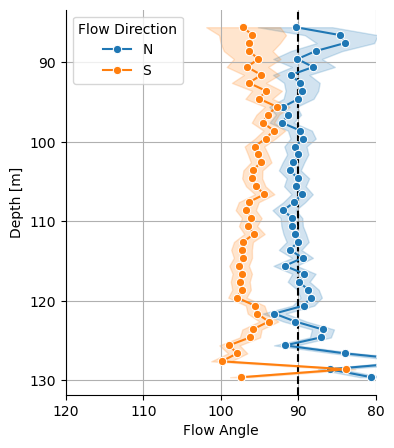

In [24]:
flow_ang = ewg.lakes.flow_angle(ds)

df_angle = flow_ang.to_dataframe().reset_index().dropna()
df_angle['angle_shifted'] = [a - 180 if a >= 180 else a for a in df_angle['angle']]
df_angle['dir'] = ['N' if a < 180 else 'S' for a in df_angle['angle']]

fig, ax = plt.subplots(figsize=(4, 5))

ax.axvline(90, color='black', linestyle='--')
sns.lineplot(df_angle, x='angle_shifted', y='range', orient='y', hue='dir', hue_order=['N', 'S'], marker='o', ax=ax)

ax.set_xlabel('Flow Angle')
ax.set_ylabel('Depth [m]')

ax.set_xlim(80, 120)
ax.invert_xaxis()
ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)
ax.grid(True)

ax.legend(title='Flow Direction')

plt.show()

In [35]:
el_data = []
for d in tqdm(ds.range.values):
    el = ewg.lakes.excursion_length(ds, d, 0)
    el_data.append(el)

df_el = pd.concat(el_data, ignore_index=True)
df_el_max = df_el.groupby(['depth', 'direction'])['excursion_length'].max().reset_index()

  0%|          | 0/45 [00:00<?, ?it/s]

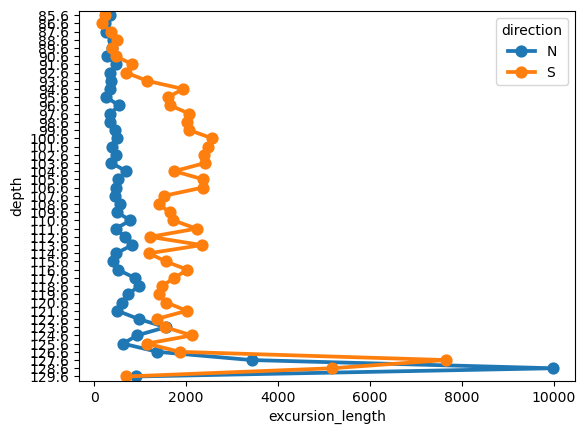

In [36]:
fig, ax = plt.subplots()
sns.pointplot(df_el_max, x='excursion_length', y='depth', hue='direction', orient='y', ax=ax)
plt.show()

In [25]:
lake = 'Zugersee'
location = 'LZN'
year = '2026'
date = '20260114'

t_start = '2025-11-06'
t_end = '2026-01-27'

mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
adcps = mreader.get_adcps()

In [26]:
adcp = adcps[0]

serial_id = adcp['serial_id']
areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
fpath = areader.locate_data_file('L0')
ds = areader.load_from_L0(fpath)
ds = areader.range_to_depth(ds)
ds = areader.run_qa(ds)
print(areader.depth, ds.attrs['cell_size'])
ds = ds.sel(time=slice(t_start, t_end))


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZN/L0\3U420.000 ...
137.77456665039062 1.5


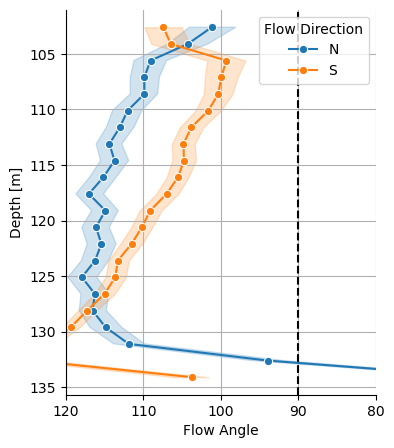

In [27]:
flow_ang = ewg.lakes.flow_angle(ds)

df_angle = flow_ang.to_dataframe().reset_index().dropna()
df_angle['angle_shifted'] = [a - 180 if a >= 180 else a for a in df_angle['angle']]
df_angle['dir'] = ['N' if a < 180 else 'S' for a in df_angle['angle']]

fig, ax = plt.subplots(figsize=(4, 5))

ax.axvline(90, color='black', linestyle='--')
sns.lineplot(df_angle, x='angle_shifted', y='range', orient='y', hue='dir', hue_order=['N', 'S'], marker='o', ax=ax)

ax.set_xlabel('Flow Angle')
ax.set_ylabel('Depth [m]')

ax.set_xlim(80, 120)
ax.invert_xaxis()
ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)
ax.grid(True)

ax.legend(title='Flow Direction')

plt.show()

In [28]:
el_data = []
for d in ds.range.values:
    el = ewg.lakes.excursion_length(ds, d, 0)
    el_data.append(el)

df_el = pd.concat(el_data, ignore_index=True)
df_el_max = df_el.groupby(['depth', 'direction'])['excursion_length'].max().reset_index()

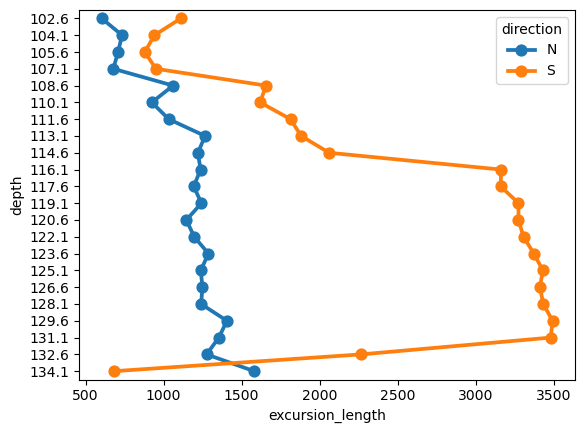

In [29]:
fig, ax = plt.subplots()
sns.pointplot(df_el_max, x='excursion_length', y='depth', hue='direction', orient='y', ax=ax)
plt.show()